In [3]:
!pip -q install sacrebleu 
!pip -q install googletrans 
!pip -q install tensorflow-addons 

^C
ERROR: Operation cancelled by user
^C
ERROR: Operation cancelled by user


In [4]:
pip install Ipython

Note: you may need to restart the kernel to use updated packages.


In [5]:
# Python
import random,re,string,itertools,timeit,sacrebleu
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sms
from tqdm.notebook import tqdm
from IPython.display import display, clear_output
from sklearn.model_selection import train_test_split

#Tensorflow
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input,Dense,LSTM,LSTMCell
from tensorflow.keras.layers import Embedding, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

#Japan Tokenizer
from janome.tokenizer import Tokenizer as janome_tokenizer
plt.style.use('seaborn-pastel')

In [6]:
!wget  http://www.manythings.org/anki/jpn-eng.zip 
!unzip  jpn-eng.zip 

--2023-02-07 12:31:20--  http://www.manythings.org/anki/jpn-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3883916 (3.7M) [application/zip]
Saving to: ‘jpn-eng.zip’

jpn-eng.zip         100%[===================>]   3.70M  11.7MB/s    in 0.3s    

2023-02-07 12:31:21 (11.7 MB/s) - ‘jpn-eng.zip’ saved [3883916/3883916]

Archive:  jpn-eng.zip
  inflating: jpn.txt                 
  inflating: _about.txt              


In [7]:
string.punctuation += '、。【】「」『』…・〽（）〜？！｡：､；･'

In [8]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~、。【】「」『』…・〽（）〜？！｡：､；･'

In [9]:
data=[]
f1= open('./jpn.txt','r')
data+=[x.rstrip().lower().split('\t')[:2] for x in tqdm(f1.readlines()
                                                       )]
f1.close()
print(f'Loaded len : {len(data)} sentences')

  0%|          | 0/93356 [00:00<?, ?it/s]

Loaded len : 93356 sentences


In [10]:
mispell_dict = {
    "aren't" : "are not",
    "can't" : "cannot",
    "couldn't" : "could not",
    "didn't" : "did not",
    "doesn't" : "does not",
    "don't" : "do not",
    "hadn't" : "had not",
    "hasn't" : "has not",
    "haven't" : "have not",
    "he'd" : "he would",
    "he'll" : "he will",
    "he's" : "he is",
    "i'd" : "i would",
    "i'd" : "i had",
    "i'll" : "i will",
    "i'm" : "i am",
    "isn't" : "is not",
    "it's" : "it is",
    "it'll":"it will",
    "i've" : "i have",
    "let's" : "let us",
    "mightn't" : "might not",
    "mustn't" : "must not",
    "shan't" : "shall not",
    "she'd" : "she would",
    "she'll" : "she will",
    "she's" : "she is",
    "shouldn't" : "should not",
    "that's" : "that is",
    "there's" : "there is",
    "they'd" : "they would",
    "they'll" : "they will",
    "they're" : "they are",
    "they've" : "they have",
    "we'd" : "we would",
    "we're" : "we are",
    "weren't" : "were not",
    "we've" : "we have",
    "what'll" : "what will",
    "what're" : "what are",
    "what's" : "what is",
    "what've" : "what have",
    "where's" : "where is",
    "who'd" : "who would",
    "who'll" : "who will",
    "who're" : "who are",
    "who's" : "who is",
    "who've" : "who have",
    "won't" : "will not",
    "wouldn't" : "would not",
    "you'd" : "you would",
    "you'll" : "you will",
    "you're" : "you are",
    "you've" : "you have",
    "'re": " are",
    "wasn't": "was not",
    "we'll":" will",
    "didn't": "did not",
    "tryin'":"trying"
}

In [11]:
mispell_re= re.compile('(%s)'%'|'.join(mispell_dict.keys()))

def preprocessing(text) -> str : 
    def replace(mat) :
        return mispell_dict[mat.group(0)]
    text=mispell_re.sub(replace,text)
    return text
    

Menambahkan Punctuation untuk bahasa Jepang

**Deleting Punctuation**

In [12]:
CP=lambda x : x.translate(str.maketrans("","",string.punctuation))

In [13]:
data=[data for data in data if len(data)==2]

In [14]:
eng_data=[CP(preprocessing(x[0])) for x in data]
jpn_data=[CP(x[1]) for x in data]

Segmenting Japanesse Data

In [15]:
token_jp = janome_tokenizer()

In [16]:
jpn_data=[' '.join([word for word in token_jp.tokenize(x,wakati=True) if word !=' ']) for x in tqdm(jpn_data)]

  0%|          | 0/93356 [00:00<?, ?it/s]

In [17]:
eng_train, eng_test, jpn_train, jpn_test = \
train_test_split(eng_data, jpn_data, test_size = 0.04, random_state = 42)

print(f"Splitting to {len(eng_train)} Train data and \
{len(eng_test)} Test data")

Splitting to 89621 Train data and 3735 Test data


Adding bos(beginning of sentence) and eos (ending of sentence) to help in decode later

In [18]:
eng_train=['bos '+x+' eos' for x in eng_train+['unk unk unk']]
jpn_train=['bos '+x+' eos' for x in jpn_train+['unk unk unk']]
eng_val = ['bos '+ x + ' eos' for x in eng_test]
jpn_val = ['bos '+ x + ' eos' for x in jpn_test]

Word Tokenizing

In [19]:
# en_tokenizer=Tokenizer(filters='') 
# en_tokenizer.fit_on_texts(eng_train)

# ##Japanesse Tokenizer
# jp_tokenizer=tf.keras.preprocessing.text.Tokenizer(filters='')
# jp_tokenizer.fit_on_texts(jpn_train)

In [20]:
# ## Size
# print(f"English Vocab Size : ", len(en_tokenizer.word_index)-3)
# print(f"Japan Vocab Size : ", len(jp_tokenizer.word_index)-3)

In [21]:
class Tokeniz(tf.keras.preprocessing.text.Tokenizer) :
    def __init__(self,data) :
        super(Tokeniz, self).__init__()
        self.data=data
    def get_tokenizer(self) :
        self.token=tf.keras.preprocessing.text.Tokenizer(filters='')
        self.token.fit_on_texts(self.data)
        return self.token
    def size(self) :
        a=self.get_tokenizer()
        print(f"Japan Vocab Size : ", len(a.word_index)-3)

In [22]:
en=Tokeniz(eng_train)
jpn=Tokeniz(jpn_train)
jp_tokenizer=jpn.get_tokenizer()
en_tokenizer=en.get_tokenizer()

Word Cloud

In [23]:
!wget https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKjp-hinted.zip

--2023-02-07 12:33:04--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKjp-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 108.177.11.128, 2607:f8b0:400c:c01::80
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|108.177.11.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121096772 (115M) [application/zip]
Saving to: ‘NotoSansCJKjp-hinted.zip’

NotoSansCJKjp-hinte 100%[===================>] 115.49M   160MB/s    in 0.7s    

2023-02-07 12:33:04 (160 MB/s) - ‘NotoSansCJKjp-hinted.zip’ saved [121096772/121096772]



In [24]:
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

In [25]:
!wget https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKjp-hinted.zip
!mkdir font
!unzip NotoSansCJKjp-hinted.zip -d ./font

--2023-02-07 12:33:05--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKjp-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 108.177.11.128, 2607:f8b0:400c:c01::80
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|108.177.11.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121096772 (115M) [application/zip]
Saving to: ‘NotoSansCJKjp-hinted.zip.1’

NotoSansCJKjp-hinte 100%[===================>] 115.49M  85.7MB/s    in 1.3s    

2023-02-07 12:33:07 (85.7 MB/s) - ‘NotoSansCJKjp-hinted.zip.1’ saved [121096772/121096772]

Archive:  NotoSansCJKjp-hinted.zip
  inflating: ./font/LICENSE_OFL.txt  
  inflating: ./font/NotoSansCJKjp-Black.otf  
  inflating: ./font/NotoSansCJKjp-Bold.otf  
  inflating: ./font/NotoSansCJKjp-DemiLight.otf  
  inflating: ./font/NotoSansCJKjp-Light.otf  
  inflating: ./font/NotoSansCJKjp-Medium.otf  
  inflating: ./font/NotoSansCJKj

In [26]:
# !wget https://raw.githubusercontent.com/kbdp1305/resources/main/Twitter.jpg
!wget https://raw.githubusercontent.com/kbdp1305/resources/main/rectangle-clipart-blue-4.jpg

--2023-02-07 12:33:12--  https://raw.githubusercontent.com/kbdp1305/resources/main/rectangle-clipart-blue-4.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16027 (16K) [image/jpeg]
Saving to: ‘rectangle-clipart-blue-4.jpg’

rectangle-clipart-b 100%[===================>]  15.65K  --.-KB/s    in 0.001s  

2023-02-07 12:33:12 (21.0 MB/s) - ‘rectangle-clipart-blue-4.jpg’ saved [16027/16027]



In [27]:
class Wordcloud () :
    def __init__(self,arr,image) :
        self.wc=WordCloud()
        self.arr=arr.word_counts
        self.image =image
    def get_words(self) :
        self.keys=list(self.arr)
        self.count=list(self.arr.values())
        return ' '.join([x for _,x in sorted(zip(self.count,self.keys),reverse=True)][2:])
    def transform(self) :
        for i in range(len(self.image)) :
            for j in range(len(self.image[i])) :
                if not any(self.image[i][j]) :
                    self.image[i][j]=np.array([255,255,255,255])
        return self.image
    def get_template(self) :
        template=self.transform()
        return ImageColorGenerator(template)
    def mask (self) :
        template=self.transform()
        return template
    def clouding_word(self) :
        font_path='./font/NotoSansCJKjp-Light.otf'
        wc=self.wc
        wc=wc.generate(self.get_words().title())
        return wc
    def plot(self) :
        wc=self.clouding_word()
        fig1,ax1=plt.subplots(figsize=(20,15))
        ax1.imshow(wc.recolor(color_func=self.get_template()),interpolation='bilinear')
        ax1.axis("off")
        
        

In [28]:
mask=np.array(Image.open('rectangle-clipart-blue-4.jpg'))
test=Wordcloud(en_tokenizer,mask)

Plotting Word Cloud

In [29]:
wordclouds=Wordcloud(en_tokenizer,image = np.array(Image.open('rectangle-clipart-blue-4.jpg')))

In [30]:
wordclouds.wc=WordCloud(background_color="white", max_words=2000, random_state=42,
               width=test.mask().shape[1], height=test.mask().shape[0])

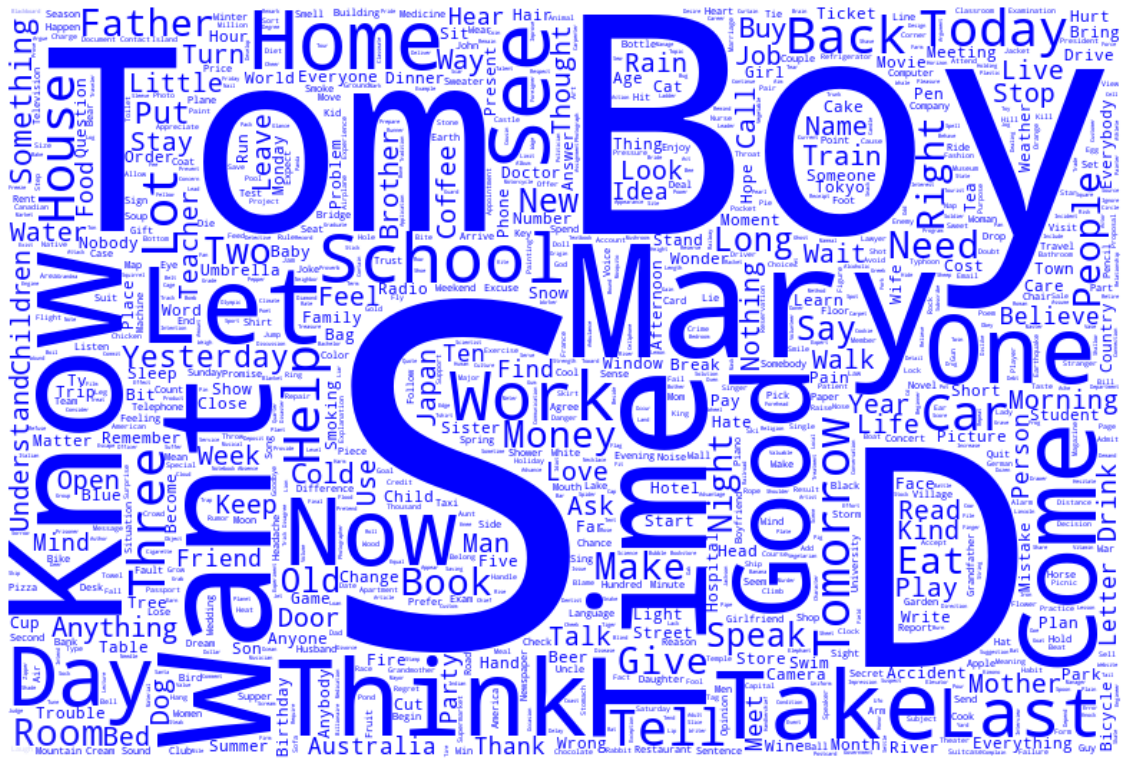

In [31]:
wordclouds.plot()

Japanesse Plot

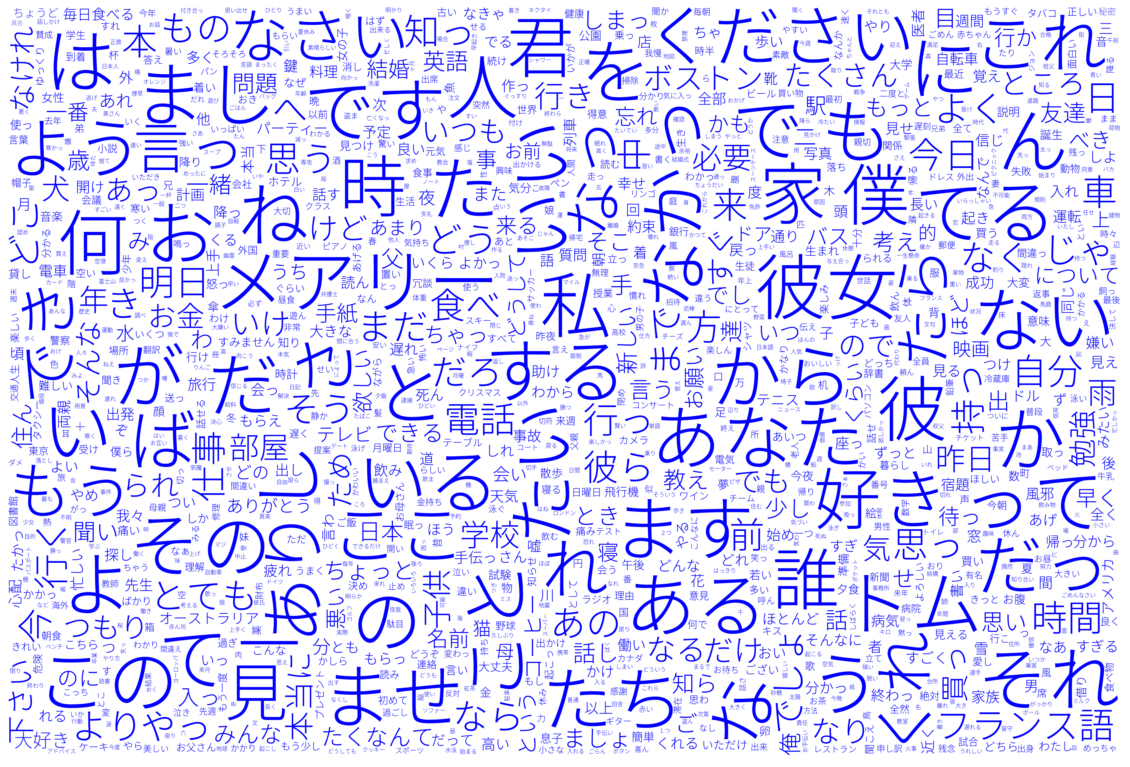

In [32]:
font_path = './font/NotoSansCJKjp-Light.otf'
wordclouds.arr=jp_tokenizer.word_counts
wordclouds.wc=WordCloud(collocations=False, background_color="white", mode="RGBA",
               max_words=6000, font_path=font_path, contour_width=1,
               scale=5, max_font_size = 50, relative_scaling=0.5,
               random_state=42, width=test.mask().shape[1], height=test.mask().shape[0])
wordclouds.plot()

Train sentences to sequences


In [33]:
def Sequences(texts, tokenizer):
    res = []
    for text in texts:
        seq = []
        for w in text.split():
            try:
                seq.append(tokenizer.word_index[w])
            except:
                seq.append(tokenizer.word_index['unk'])
        res.append(seq)
    return res

In [34]:
data_en = en_tokenizer.texts_to_sequences(eng_train)
data_jp = jp_tokenizer.texts_to_sequences(jpn_train)

In [35]:
val_en = Sequences(eng_val, en_tokenizer)
val_jp = Sequences(jpn_val, jp_tokenizer)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


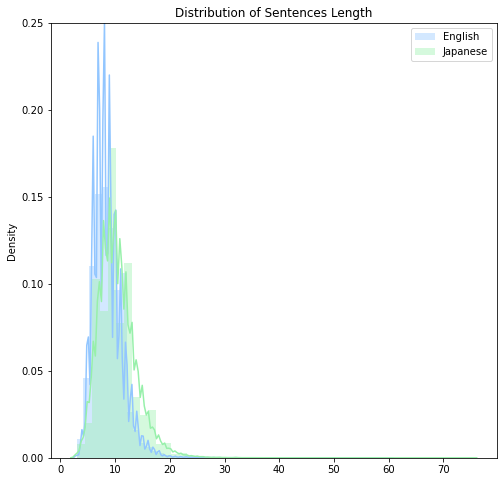

In [36]:
import seaborn as sns
plt.figure(figsize = (8,8))
sns.distplot([len(x) for x in data_en], label='English')
sns.distplot([len(x) for x in data_jp], label='Japanese')
plt.title('Distribution of Sentences Length')
plt.ylim(0,0.25)
plt.legend()
plt.show()

Check mac length


In [37]:
max_en= max([len(x) for x in data_en]+ [len(x) for x in val_en])
max_jp= max([len(x) for x in data_jp]+ [len(x) for x in val_jp])

In [38]:

print(f'Maximum length of English sequences is  {max_en}')
print(f'Maximum length of Japanese sequences is {max_jp}')

Maximum length of English sequences is  60
Maximum length of Japanese sequences is 75


Padding

In [39]:
data_en=pad_sequences(data_en,padding='post',maxlen=max_en)
data_jp=pad_sequences(data_jp,padding='post',maxlen=max_jp)
val_en = pad_sequences(val_en, padding='post', maxlen = max_en)
val_jp = pad_sequences(val_jp, padding='post', maxlen = max_jp)

Model

In [40]:
def max_len(tensor):
    """
    Get max len in Sequences
    """
    return max( len(t) for t in tensor)

In [43]:
# Max len  
Tx=max_len(data_en)
Ty=max_len(data_jp)
input_vocab_size = len(en_tokenizer.word_index) + 1   # English
output_vocab_size = len(jp_tokenizer.word_index) + 1  # Japanese

# Changing to TF data
dataset = (tf.data.Dataset.from_tensor_slices((data_en, data_jp))
           .shuffle(BUFFER_SIZE)
           .batch(BATCH_SIZE, drop_remainder=True)
          )

val_dataset = (tf.data.Dataset.from_tensor_slices((val_en, val_jp))
               .batch(BATCH_SIZE)
              )

ENCODER DECODER OF SEQ2SEQ Model

In [42]:
epochs = 7
BATCH_SIZE = 64
BUFFER_SIZE = len(data_jp)
steps_per_epoch = BUFFER_SIZE//BATCH_SIZE
val_steps_per_epoch = len(val_jp) // BATCH_SIZE
embedding_dims = 256
rnn_units = 1024
dense_units = 1024
Dtype = tf.float32

In [138]:
class Encoder(tf.keras.Model) :
    def __init__(self,vocab_size,embedding_dim,enc_units,batch_sz) :
        super(Encoder,self).__init__()
        self.batch_sz=batch_sz
        self.enc_units=enc_units
        self.embedding=tf.keras.layers.Embedding(input_dim=input_vocab_size,output_dim=embedding_dim)
        self.lstm_layer=tf.keras.layers.LSTM(self.enc_units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        
        
    def call(self,x,hidden) :
        x=self.embedding(x) 
        output,h,c=self.lstm_layer(x,initial_state=hidden)
        return output,h,c
    def initialize_hidden_state(self) :
        return [tf.zeros((self.batch_sz,self.enc_units)),tf.zeros((self.batch_sz,self.enc_units))]

Test encoder

In [45]:
encoder = Encoder(input_vocab_size, embedding_dims, rnn_units, BATCH_SIZE)

In [46]:
example_input_batch, example_target_batch = next(iter(dataset))

In [47]:
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_h, sample_c = encoder(example_input_batch, sample_hidden)

2023-02-07 12:33:55.823285: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [48]:
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder h vecotr shape: (batch size, units) {}'.format(sample_h.shape))
print ('Encoder c vector shape: (batch size, units) {}'.format(sample_c.shape))

Encoder output shape: (batch size, sequence length, units) (64, 60, 1024)
Encoder h vecotr shape: (batch size, units) (64, 1024)
Encoder c vector shape: (batch size, units) (64, 1024)


In [49]:
Ty

75

In [50]:
class Decoder(tf.keras.Model) :
    def __init__(self,vocab_size,embedding_dim,dec_units,batch_sz) :
        super(Decoder,self).__init__()
        self.batch_sz=batch_sz
        self.dec_units=dec_units
        self.embedding =tf.keras.layers.Embedding(vocab_size,embedding_dim)
        self.fc=tf.keras.layers.Dense(vocab_size) #Final Dense layer on which softmax will be applied
        self.decoder_rnn_cell = tf.keras.layers.LSTMCell(self.dec_units)  # Define the fundamental cell for decoder recurrent structure
        self.sampler=tfa.seq2seq.sampler.TrainingSampler()
        self.attention_mechanism = self.build_attention_mechanism(self.dec_units, 
                                                              None, self.batch_sz*[Tx])
        self.rnn_cell = self.build_rnn_cell(batch_sz)
        self.decoder=tfa.seq2seq.BasicDecoder(self.rnn_cell,sampler=self.sampler,output_layer=self.fc)
        
    def build_rnn_cell(self,batch_sz) :
            return tfa.seq2seq.AttentionWrapper(self.decoder_rnn_cell,self.attention_mechanism,attention_layer_size=self.dec_units)
        
    def build_attention_mechanism(self,dec_units,memory,memory_sequence_length) : 
            return tfa.seq2seq.BahdanauAttention(units=dec_units,memory_sequence_length=memory_sequence_length)
    
    def build_initial_state(self, batch_sz, encoder_state, Dtype):
        decoder_initial_state = self.rnn_cell.get_initial_state(batch_size=batch_sz, dtype=Dtype)
        decoder_initial_state = decoder_initial_state.clone(cell_state=encoder_state)
        return decoder_initial_state
    def call(self,inputs,initial_state) :
            x=self.embedding(inputs)
            outputs,_,_=self.decoder(x,initial_state=initial_state,sequence_length=self.batch_sz*[Ty-1])
            return outputs

In [51]:
decoder = Decoder(output_vocab_size, embedding_dims, rnn_units, BATCH_SIZE)

In [ ]:
output_vocab_size

In [54]:
sample_x = tf.random.uniform((BATCH_SIZE, Ty))
decoder.attention_mechanism.setup_memory(sample_output)
initial_state = decoder.build_initial_state(BATCH_SIZE, [sample_h, sample_c], tf.float32)

In [56]:
print("Decoder Outputs Shape: ", sample_decoder_outputs.rnn_output.shape)

Decoder Outputs Shape:  (64, 74, 17759)


In [55]:
sample_decoder_outputs = decoder(sample_x, initial_state)

In [57]:
print("Decoder Outputs Shape: ", sample_decoder_outputs.rnn_output.shape)


Decoder Outputs Shape:  (64, 74, 17759)


In [64]:
optimizer = tf.keras.optimizers.Adam()
def loss_function(real, pred):
  # real shape = (BATCH_SIZE, max_length_output)
  # pred shape = (BATCH_SIZE, max_length_output, tar_vocab_size )
    cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss = cross_entropy(y_true=real, y_pred=pred)
    mask = tf.logical_not(tf.math.equal(real,0))   #output 0 for y=0 else output 1
    mask = tf.cast(mask, dtype=loss.dtype)  
    loss = mask* loss
    loss = tf.reduce_mean(loss)
    return loss

Object based saving ----  Checkpoint

In [ ]:
checkpoint-dir='./training_checkpoints'
checkpoint_prefix=os.path.join(checkpoint_dir,"ckpt")
checkpoint=tf.train.Checkpoint(optimizer=tf.keras.optimizers.Adam(),encoder=encoder,decoder=decoder)

In [63]:
@tf.function
def train_step(inp,targ,enc_hideen) :
    loss=0
    with tf.GradientTape() as tape :
        enc_output,enc_h,enc_c=encoder(inp,enc_hidden)
        dec_input=targ[:,:-1] #Ignore end token
        real=targ[:,1:] # Ignore start token
        
        #Set attentionMechanism object with encoder outputs
        decoder.attention_mechanism.setup_memory(enc_output)
        decoder_initial_state=decoder.build_initial_state(BATCH_SIZE,[enc_h,enc_c],tf.float32)
        pred=decoder(dec_input,decoder_initial_state)
        logits=pred.rnn_output
        loss=loss_function(real,logits)
    variables=encoder.trainable_variables+decoder.trainable_variables
    gradients=tape.gradient(loss,variables)
    optimizer.apply_gradients(zip(gradients,variables))
    return loss

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_h, enc_c = encoder(inp, enc_hidden)


    dec_input = targ[ : , :-1 ] # Ignore <end> token
    real = targ[ : , 1: ]         # ignore <start> token

    # Set the AttentionMechanism object with encoder_outputs
    decoder.attention_mechanism.setup_memory(enc_output)

    # Create AttentionWrapperState as initial_state for decoder
    decoder_initial_state = decoder.build_initial_state(BATCH_SIZE, [enc_h, enc_c], tf.float32)
    pred = decoder(dec_input, decoder_initial_state)
    logits = pred.rnn_output
    loss = loss_function(real, logits)

  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))

  return loss

In [ ]:
optimizer = tf.keras.optimizers.Adam()


def loss_function(real, pred):
  # real shape = (BATCH_SIZE, max_length_output)
  # pred shape = (BATCH_SIZE, max_length_output, tar_vocab_size )
  cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
  loss = cross_entropy(y_true=real, y_pred=pred)
  mask = tf.logical_not(tf.math.equal(real,0))   #output 0 for y=0 else output 1
  mask = tf.cast(mask, dtype=loss.dtype)  
  loss = mask* loss
  loss = tf.reduce_mean(loss)
  return loss

In [66]:
EPOCHS = 7

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0
  # print(enc_hidden[0].shape, enc_hidden[1].shape)

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  
  if (epoch+1)%2==0 :
        encoder.save_weights('encoderNetwork')
        decoder.save_weights('decoderNetwork')
        
  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.3845
Epoch 1 Batch 100 Loss 0.4141
Epoch 1 Batch 200 Loss 0.4066
Epoch 1 Batch 300 Loss 0.4097
Epoch 1 Batch 400 Loss 0.3622
Epoch 1 Batch 500 Loss 0.3844
Epoch 1 Batch 600 Loss 0.3561
Epoch 1 Batch 700 Loss 0.4276
Epoch 1 Batch 800 Loss 0.3848
Epoch 1 Batch 900 Loss 0.4029
Epoch 1 Batch 1000 Loss 0.3323
Epoch 1 Batch 1100 Loss 0.3517
Epoch 1 Batch 1200 Loss 0.3550
Epoch 1 Batch 1300 Loss 0.2894
Epoch 1 Loss 0.3616
Time taken for 1 epoch 818.6320266723633 sec

Epoch 2 Batch 0 Loss 0.2825
Epoch 2 Batch 100 Loss 0.2675
Epoch 2 Batch 200 Loss 0.2988
Epoch 2 Batch 300 Loss 0.2737
Epoch 2 Batch 400 Loss 0.2166
Epoch 2 Batch 500 Loss 0.2915
Epoch 2 Batch 600 Loss 0.2528
Epoch 2 Batch 700 Loss 0.2543
Epoch 2 Batch 800 Loss 0.3024
Epoch 2 Batch 900 Loss 0.2152
Epoch 2 Batch 1000 Loss 0.2733
Epoch 2 Batch 1100 Loss 0.2446
Epoch 2 Batch 1200 Loss 0.2245
Epoch 2 Batch 1300 Loss 0.2715
Epoch 2 Loss 0.2540
Time taken for 1 epoch 818.381735086441 sec

Epoch 3 Batch 0 Loss 0.17

In [60]:
import time

In [ ]:
tf.train.Checkpoint(optimizer=tf.keras.optimizers.Adam(),encoder=encoder,decoder=decoder)

In [ ]:
encoder.save_weights('encoderNetwork')

In [ ]:
decoder.save_weights('decoderNetwork')

In [ ]:
encoder.load_weights('encoderNetwork')

In [ ]:
decoder.load_weights('decoderNetwork')

BeamSearchDecoder

In [147]:
def beam_evaluate_sentence(input_raw, beam_width=3) :
    input_raw=CP(preprocessing(input_raw))
    input_lines=['bos ' + input_raw + '']
    input_sequences,unique=[],[]
    for line in input_lines :
        temp=[]
        for w in line.split(' ') :
            try :
                temp.append(en_tokenizer.word_index[w])
            except :
                unique.append(w)
                temp.append(en_tokenizer.word_index['unk'])
        input_sequences.append(temp)
    input_sequences=tf.keras.preprocessing.sequence.pad_sequences(input_sequences,
                                                          maxlen=Tx,
                                                     padding='post')
    inp = tf.convert_to_tensor(input_sequences)
    inference_batch_size=inp.shape[0]
    enc_start_state = [tf.zeros((inference_batch_size, rnn_units)), tf.zeros((inference_batch_size,rnn_units))]
    emb=encoder.embedding(inp)
    enc_out, enc_h, enc_c = encoder.lstm_layer(emb, enc_start_state)
    dec_h=enc_h
    dec_c=enc_c
    
    start_tokens = tf.fill([inference_batch_size], jp_tokenizer.word_index['bos'])
    end_token = jp_tokenizer.word_index['eos']
    enc_out = tfa.seq2seq.tile_batch(enc_out, multiplier=beam_width)
    decoder.attention_mechanism.setup_memory(enc_out)
    hidden_state = tfa.seq2seq.tile_batch([enc_h, enc_c], multiplier=beam_width)
    decoder_initial_state = decoder.rnn_cell.get_initial_state(batch_size=beam_width*inference_batch_size, dtype=tf.float32)
    decoder_initial_state = decoder_initial_state.clone(cell_state=hidden_state)
    decoder_instance = tfa.seq2seq.BeamSearchDecoder(decoder.rnn_cell,beam_width=beam_width, output_layer=decoder.fc)
    decoder_embedding_matrix = decoder.embedding.variables[0]
    outputs, final_state, sequence_lengths = decoder_instance(decoder_embedding_matrix, start_tokens=start_tokens, end_token=end_token, initial_state=decoder_initial_state) 
    final_outputs = tf.transpose(outputs.predicted_ids, perm=(0,2,1))
    beam_scores = tf.transpose(outputs.beam_search_decoder_output.scores, perm=(0,2,1))

    return final_outputs.numpy(), beam_scores.numpy()

In [217]:
def beam_translate(sentence):
  result, beam_scores = beam_evaluate_sentence(sentence)
  print(result.shape, beam_scores.shape)
  for beam, score in zip(result, beam_scores):
    print(beam.shape, score.shape)
    output = jp_tokenizer.sequences_to_texts(beam)
    output = [a[:a.index('eos')] for a in output]
    beam_score = [a.sum() for a in score]
    print('Input: %s' % (sentence))
    for i in range(len(output)):
      print('{} Predicted translation: {}  {}'.format(i+1, output[i], beam_score[i]))
      
    
    

In [220]:
sentence='hi, i see you tomorrow'
beam_translate(sentence)

(1, 3, 12) (1, 3, 12)
(3, 12) (3, 12)
Input: hi, i see you tomorrow
1 Predicted translation: 明日 は お 会い し ましょ う   -58.550514221191406
2 Predicted translation: 明日 は お 会い する こと が わかり ます よ   -69.53292846679688
3 Predicted translation: 明日 は お 会い する こと が ある ん です よ   -78.18229675292969


In [221]:
git commit -m "translate sheet into Japan"

SyntaxError: invalid syntax (830229249.py, line 1)

Note: you may need to restart the kernel to use updated packages.


AttributeError: 'NoneType' object has no attribute 'group'

In [ ]:
translat